In [1]:
!git clone https://github.com/haian1910/Stable-Diffusion-from-scratch.git

Cloning into 'Stable-Diffusion-from-scratch'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 69 (delta 34), reused 52 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 913.18 KiB | 3.30 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [2]:
import sys, types
sys.modules['imp'] = types.SimpleNamespace(reload=lambda mod: importlib.reload(mod))

%load_ext autoreload
%autoreload 2

In [3]:
!pip install -q -r /content/Stable-Diffusion-from-scratch/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 43.9 MB/s eta 0:00:00


In [4]:
import os, requests

data_dir = "/content/Stable-Diffusion-from-scratch/data"
os.makedirs(data_dir, exist_ok=True)

ckpt_url = "https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5/resolve/main/v1-5-pruned-emaonly.ckpt"
ckpt_path = os.path.join(data_dir, "v1-5-pruned-emaonly.ckpt")

print("Downloading model (~4GB)... please wait 5–10 minutes")

with requests.get(ckpt_url, stream=True) as r:
    r.raise_for_status()
    with open(ckpt_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

print("Download completed:", ckpt_path)


Download completed: /content/Stable-Diffusion-from-scratch/data/v1-5-pruned-emaonly.ckpt


In [ ]:
!ls -lh /content/Stable-Diffusion-from-scratch/data/v1-5-pruned-emaonly.ckpt


-rw-r--r-- 1 root root 4.0G Nov  6 11:29 /content/Stable-Diffusion-from-scratch/data/v1-5-pruned-emaonly.ckpt


Using device: cuda


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


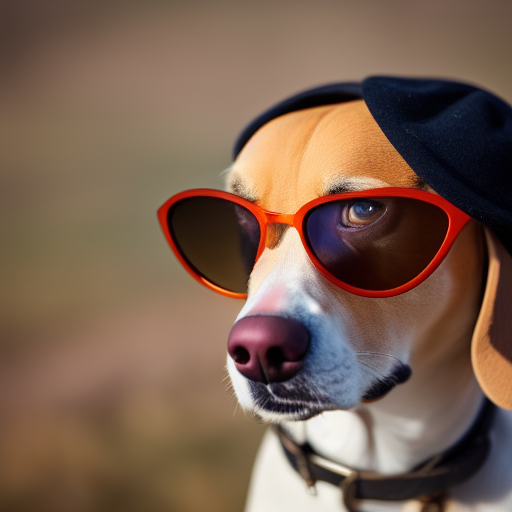

In [ ]:
import sys
sys.path.append("/content/Stable-Diffusion-from-scratch/sd")
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer(
    "/content/Stable-Diffusion-from-scratch/data/vocab.json",
    merges_file="/content/Stable-Diffusion-from-scratch/data/merges.txt"
)

model_file = "/content/Stable-Diffusion-from-scratch/data/v1-5-pruned-emaonly.ckpt"

models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
# prompt = "A cat stretching on the floor, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
image_path = "../images/dog.jpg"
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 20
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)


Generating image 1/3...
Prompt: Naruto Uzumaki in sage mode, highly detailed, ultra sharp, cinematic


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


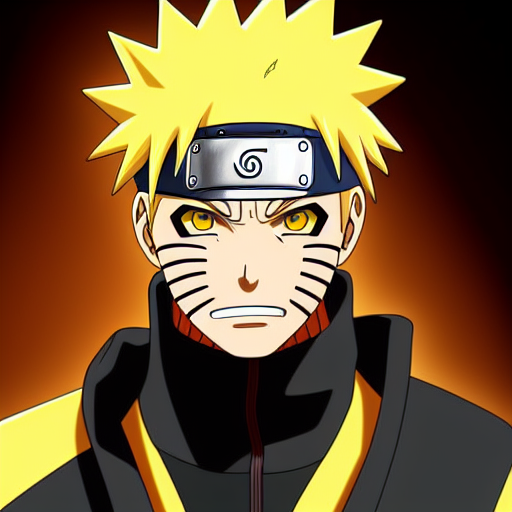


Generating image 2/3...
Prompt: Sasuke Uchiha with sharingan eyes, dramatic lighting, highly detailed


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


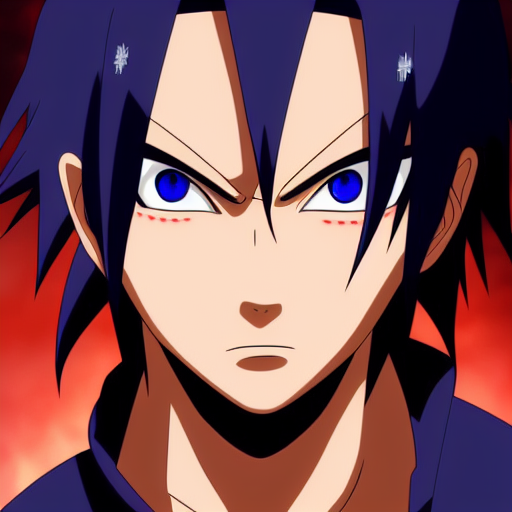


Generating image 3/3...
Prompt: Sakura Haruno portrait, beautiful anime style, highly detailed, cinematic lighting


100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


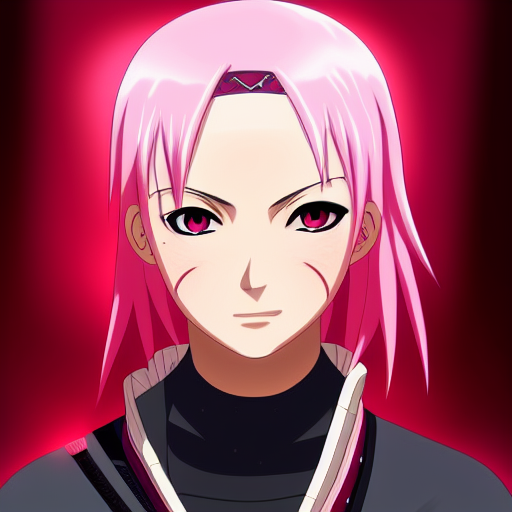

In [ ]:
prompts = [
    "Naruto Uzumaki in sage mode, highly detailed, ultra sharp, cinematic",
    "Sasuke Uchiha with sharingan eyes, dramatic lighting, highly detailed",
    "Sakura Haruno portrait, beautiful anime style, highly detailed, cinematic lighting",
]

# Generate images
for i, prompt in enumerate(prompts):
    print(f"\nGenerating image {i+1}/{len(prompts)}...")
    print(f"Prompt: {prompt}")

    image = pipeline.generate(
        prompt=prompt,
        models=models,
        tokenizer=tokenizer,
        uncond_prompt="blurry, low quality, distorted",
        seed=42,
        cfg_scale=7.5,
        n_inference_steps=50,
        device=DEVICE
    )

    img_pil = Image.fromarray(image)
    display(img_pil)

In [ ]:
from datasets import load_dataset

ds = load_dataset("lambdalabs/naruto-blip-captions", split="train[:100]")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

data/train-00000-of-00002-12944970063701(…):   0%|          | 0.00/344M [00:00<?, ?B/s]

data/train-00001-of-00002-cefa2f480689f1(…):   0%|          | 0.00/357M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

Sample 1: a man with dark hair and brown eyes


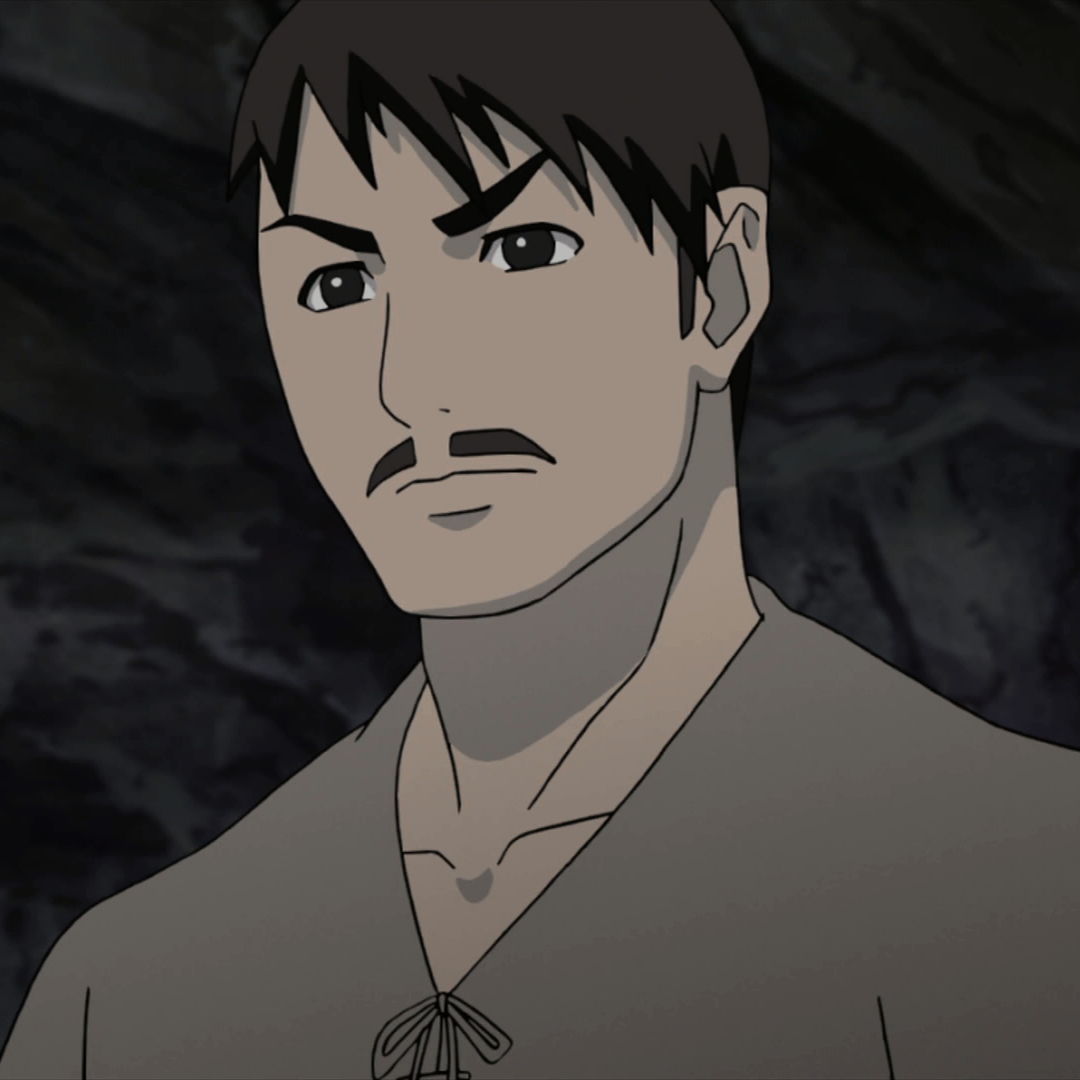

--------------------------------------------------------------------------------
Sample 2: a man in a hoodie with a fire in the background


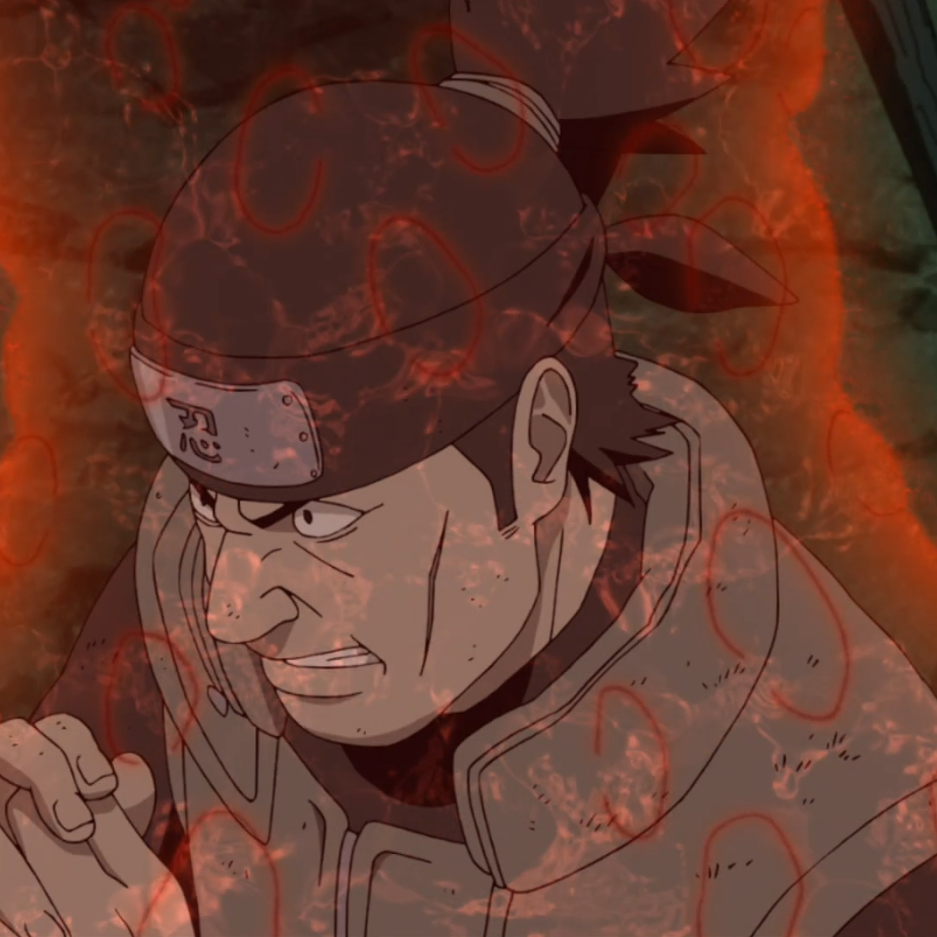

--------------------------------------------------------------------------------
Sample 3: a man with a red hair and a black shirt


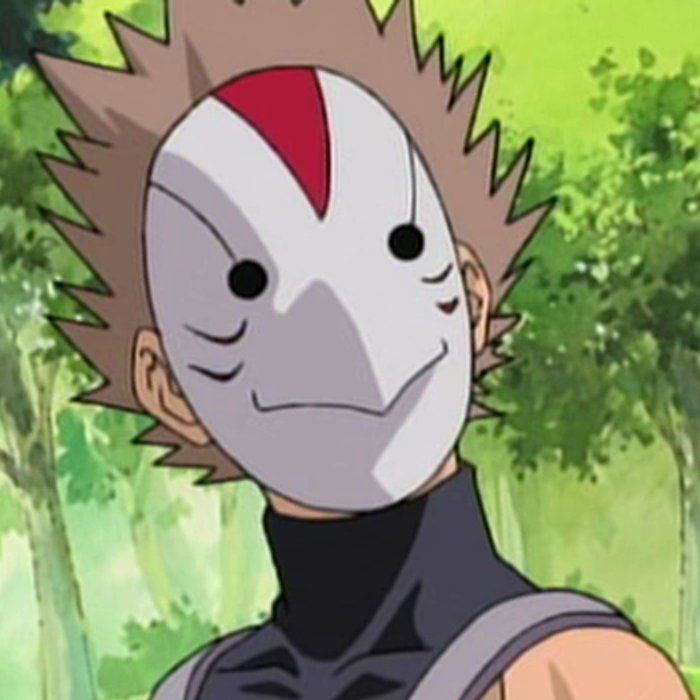

--------------------------------------------------------------------------------
Sample 4: a man in a blue shirt and headband


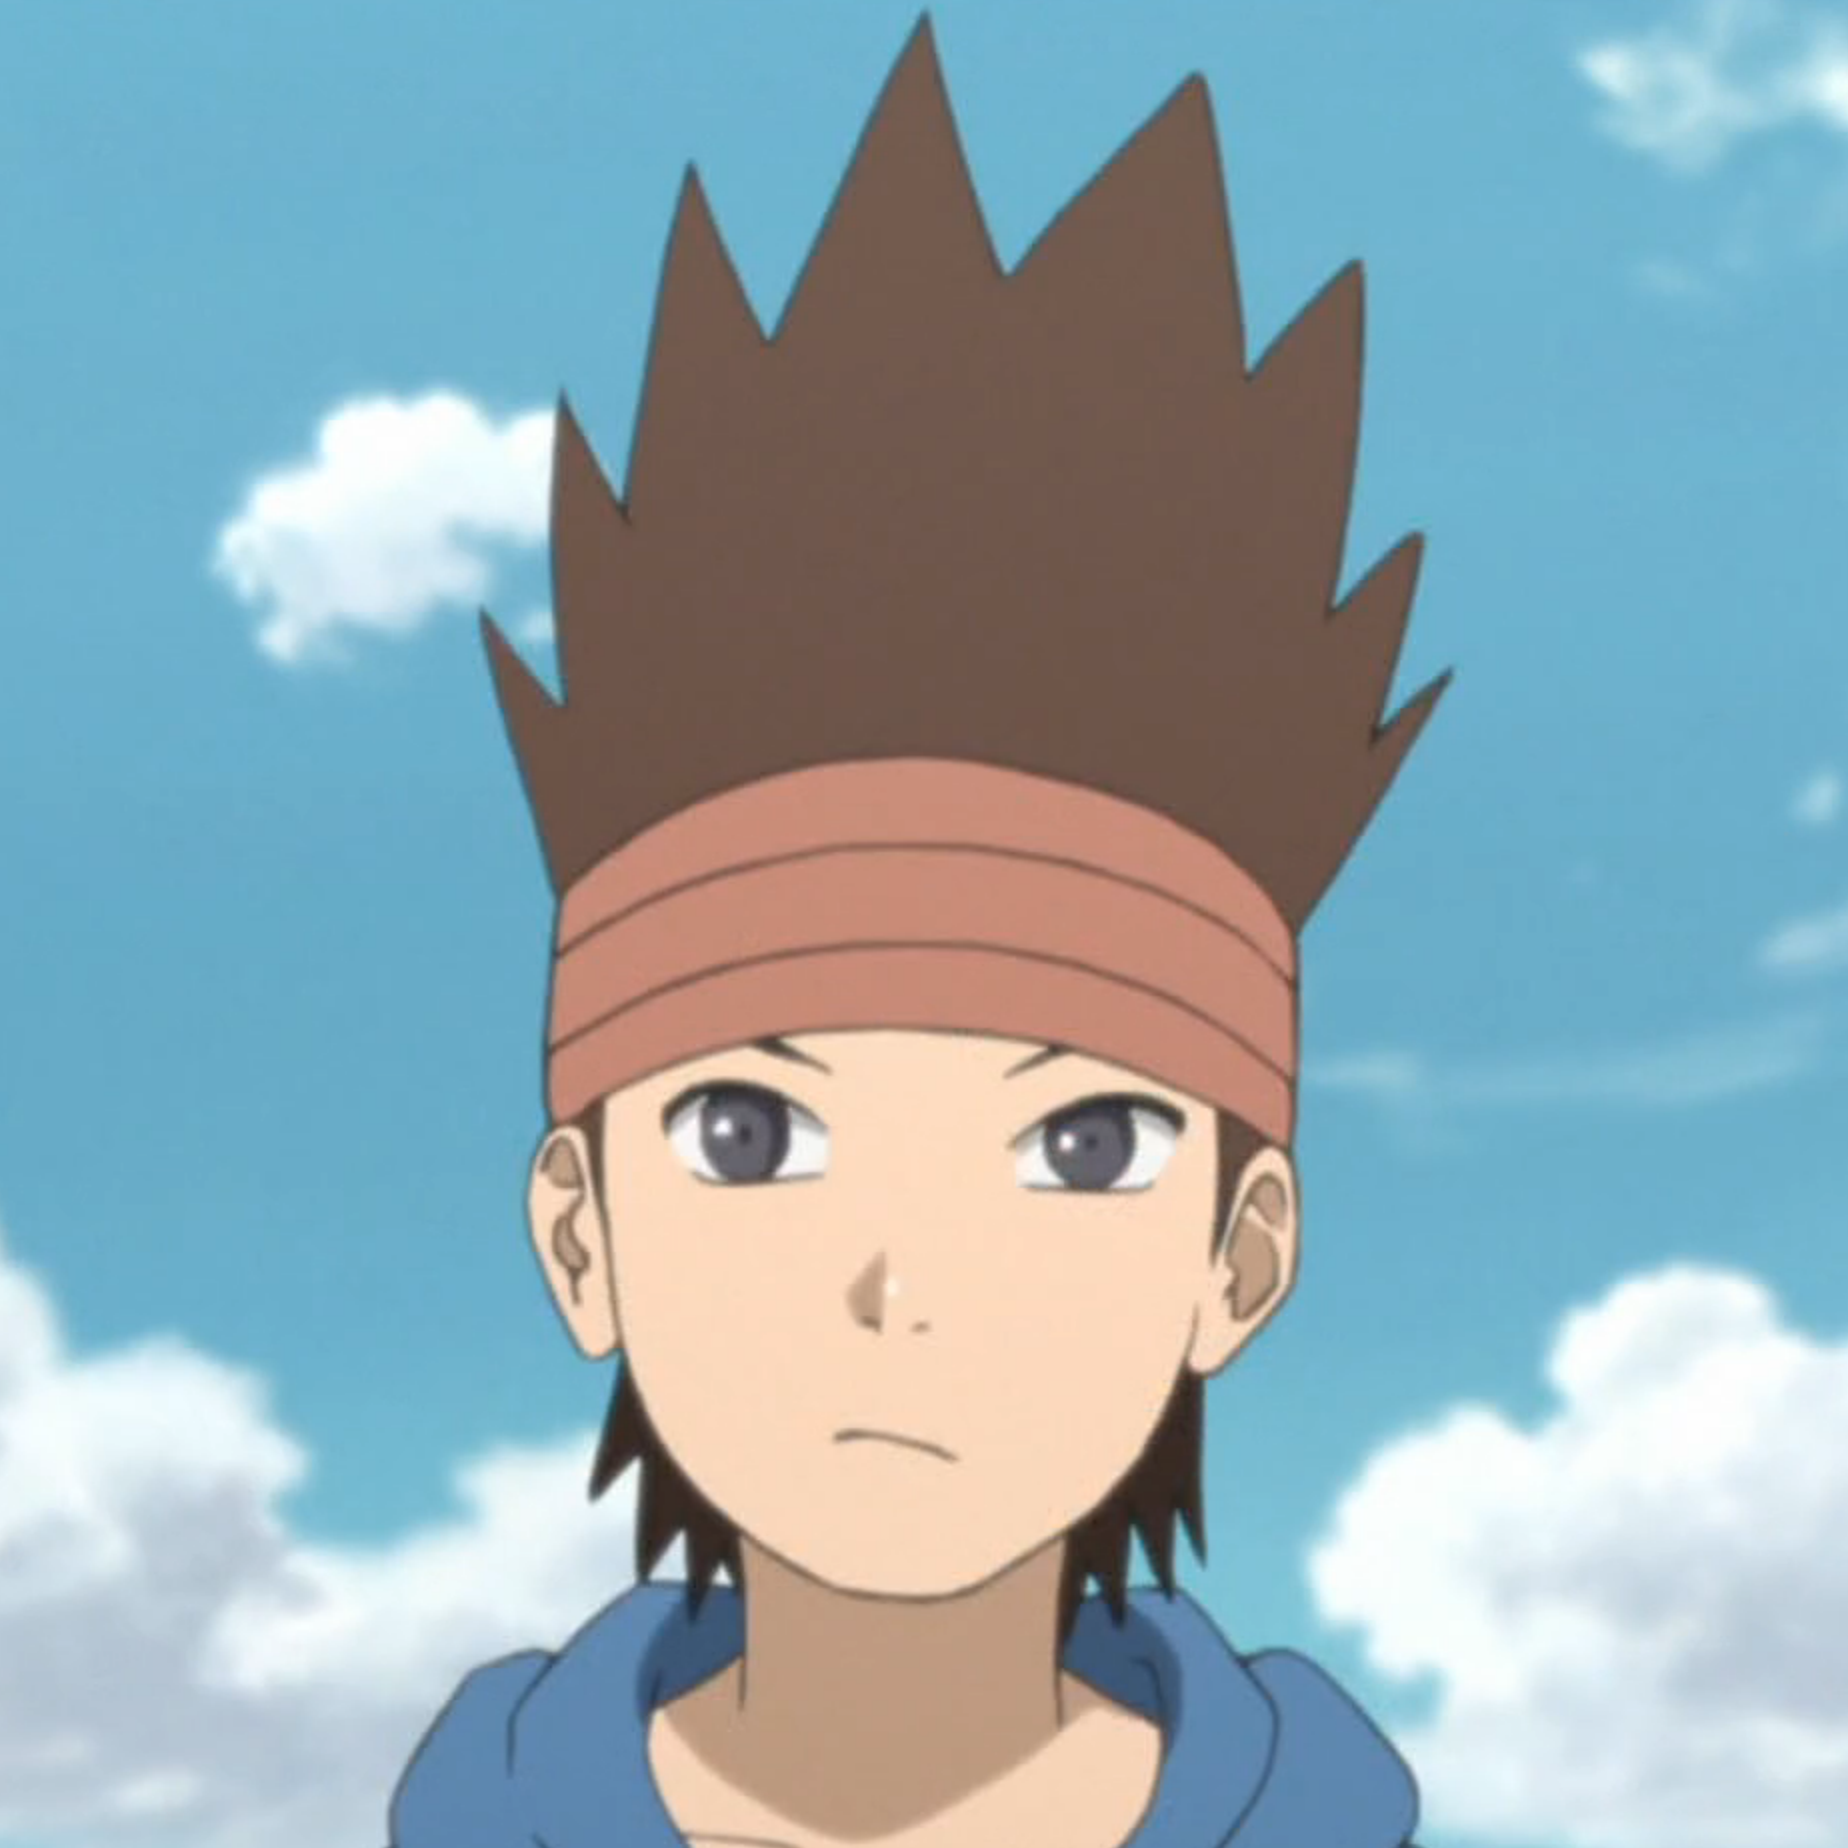

--------------------------------------------------------------------------------
Sample 5: a dog in a blue shirt laying on the ground


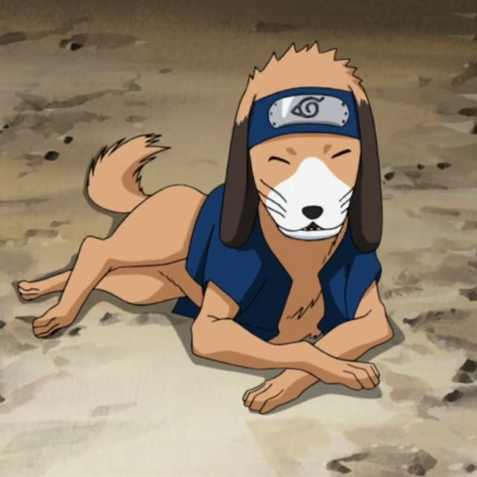

--------------------------------------------------------------------------------


In [ ]:
for i in range(5):
    sample = ds["train"][i]
    print(f"Sample {i+1}:")
    print(f"Caption: {sample['text']}")
    print(f"Image: {sample['image']}")
    print("-" * 80)

In [9]:
!python /content/Stable-Diffusion-from-scratch/sd/lora_train.py


Using device: cuda
LoRA Rank: 8, Alpha: 1.0

=== Loading Dataset ===
Repo card metadata block was not found. Setting CardData to empty.
Dataset size: 50 samples

=== Loading Tokenizer ===

=== Loading Models ===
Original diffusion parameters: 859,520,964

=== Injecting LoRA ===
Applied LoRA to: unet.encoders.1.1.attention_2.q_proj
Applied LoRA to: unet.encoders.1.1.attention_2.v_proj
Applied LoRA to: unet.encoders.2.1.attention_2.q_proj
Applied LoRA to: unet.encoders.2.1.attention_2.v_proj
Applied LoRA to: unet.encoders.4.1.attention_2.q_proj
Applied LoRA to: unet.encoders.4.1.attention_2.v_proj
Applied LoRA to: unet.encoders.5.1.attention_2.q_proj
Applied LoRA to: unet.encoders.5.1.attention_2.v_proj
Applied LoRA to: unet.encoders.7.1.attention_2.q_proj
Applied LoRA to: unet.encoders.7.1.attention_2.v_proj
Applied LoRA to: unet.encoders.8.1.attention_2.q_proj
Applied LoRA to: unet.encoders.8.1.attention_2.v_proj
Applied LoRA to: unet.bottleneck.1.attention_2.q_proj
Applied LoRA to: un

In [14]:
!python /content/Stable-Diffusion-from-scratch/sd/inference_lora.py

Using device: cuda

Loading tokenizer...
Loading base model...
Injecting LoRA layers...
Applied LoRA to: unet.encoders.1.1.attention_2.q_proj
Applied LoRA to: unet.encoders.1.1.attention_2.v_proj
Applied LoRA to: unet.encoders.2.1.attention_2.q_proj
Applied LoRA to: unet.encoders.2.1.attention_2.v_proj
Applied LoRA to: unet.encoders.4.1.attention_2.q_proj
Applied LoRA to: unet.encoders.4.1.attention_2.v_proj
Applied LoRA to: unet.encoders.5.1.attention_2.q_proj
Applied LoRA to: unet.encoders.5.1.attention_2.v_proj
Applied LoRA to: unet.encoders.7.1.attention_2.q_proj
Applied LoRA to: unet.encoders.7.1.attention_2.v_proj
Applied LoRA to: unet.encoders.8.1.attention_2.q_proj
Applied LoRA to: unet.encoders.8.1.attention_2.v_proj
Applied LoRA to: unet.bottleneck.1.attention_2.q_proj
Applied LoRA to: unet.bottleneck.1.attention_2.v_proj
Applied LoRA to: unet.decoders.3.1.attention_2.q_proj
Applied LoRA to: unet.decoders.3.1.attention_2.v_proj
Applied LoRA to: unet.decoders.4.1.attention_2.q

Using device: cuda

Loading tokenizer...
Loading base model...
Injecting LoRA layers...
Applied LoRA to: unet.encoders.1.1.attention_2.q_proj
Applied LoRA to: unet.encoders.1.1.attention_2.v_proj
Applied LoRA to: unet.encoders.2.1.attention_2.q_proj
Applied LoRA to: unet.encoders.2.1.attention_2.v_proj
Applied LoRA to: unet.encoders.4.1.attention_2.q_proj
Applied LoRA to: unet.encoders.4.1.attention_2.v_proj
Applied LoRA to: unet.encoders.5.1.attention_2.q_proj
Applied LoRA to: unet.encoders.5.1.attention_2.v_proj
Applied LoRA to: unet.encoders.7.1.attention_2.q_proj
Applied LoRA to: unet.encoders.7.1.attention_2.v_proj
Applied LoRA to: unet.encoders.8.1.attention_2.q_proj
Applied LoRA to: unet.encoders.8.1.attention_2.v_proj
Applied LoRA to: unet.bottleneck.1.attention_2.q_proj
Applied LoRA to: unet.bottleneck.1.attention_2.v_proj
Applied LoRA to: unet.decoders.3.1.attention_2.q_proj
Applied LoRA to: unet.decoders.3.1.attention_2.v_proj
Applied LoRA to: unet.decoders.4.1.attention_2.q

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


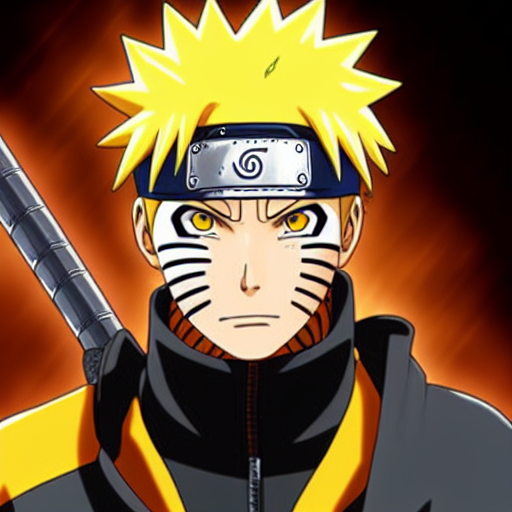


Generating image 2/3...
Prompt: Sasuke Uchiha with sharingan eyes, dramatic lighting, highly detailed


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


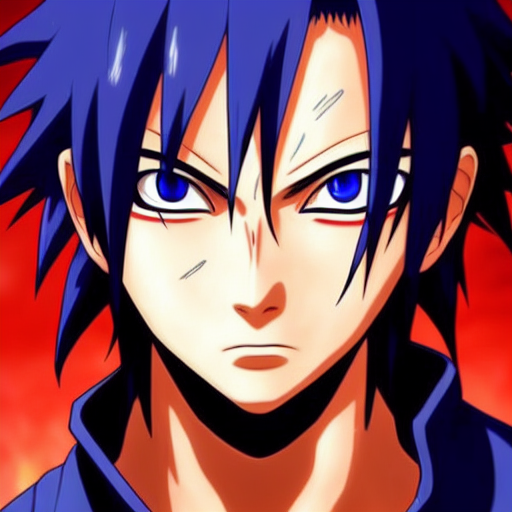


Generating image 3/3...
Prompt: Sakura Haruno portrait, beautiful anime style, highly detailed, cinematic lighting


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


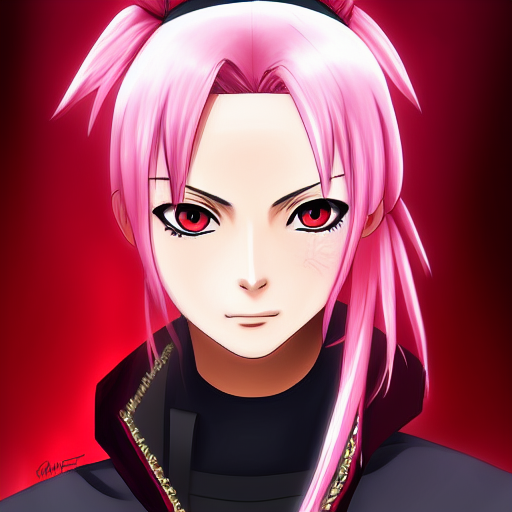


Generation complete!


In [15]:
import sys
sys.path.append("/content/Stable-Diffusion-from-scratch/sd")
import torch
from PIL import Image
from IPython.display import display
from transformers import CLIPTokenizer
import numpy as np
from IPython.display import display
from model_loader import preload_models_from_standard_weights
from pipeline import generate
from lora import inject_lora_to_diffusion_unet, load_lora_weights

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/content/Stable-Diffusion-from-scratch/data/v1-5-pruned-emaonly.ckpt"
VOCAB_PATH = "/content/Stable-Diffusion-from-scratch/data/vocab.json"
MERGES_PATH = "/content/Stable-Diffusion-from-scratch/data/merges.txt"

# LoRA Configuration
LORA_RANK = 8
LORA_ALPHA = 1.0
LORA_WEIGHTS_PATH = "/content/Stable-Diffusion-from-scratch/checkpoints_lora/lora_epoch_4.pt"

def load_model_with_lora(model_path, lora_path, device):
    """Load base model and inject LoRA weights"""
    print("Loading base model...")
    models = preload_models_from_standard_weights(model_path, device)

    print("Injecting LoRA layers...")
    diffusion = models['diffusion']
    diffusion, _ = inject_lora_to_diffusion_unet(
        diffusion,
        rank=LORA_RANK,
        alpha=LORA_ALPHA
    )

    print(f"Loading LoRA weights from {lora_path}...")
    diffusion = load_lora_weights(diffusion, lora_path)

    models['diffusion'] = diffusion
    return models

def generate_image(
    prompt,
    models,
    tokenizer,
    uncond_prompt="",
    seed=42,
    cfg_scale=7.5,
    num_inference_steps=50,
    device="cuda"
):
    """Generate image using the model with LoRA"""
    output_image = generate(
        prompt=prompt,
        uncond_prompt=uncond_prompt,
        input_image=None,
        strength=0.8,
        do_cfg=True,
        cfg_scale=cfg_scale,
        sampler_name="ddpm",
        n_inference_steps=num_inference_steps,
        seed=seed,
        models=models,
        device=device,
        idle_device="cpu",
        tokenizer=tokenizer,
    )

    return output_image


print(f"Using device: {DEVICE}\n")

# Load tokenizer
print("Loading tokenizer...")
tokenizer = CLIPTokenizer(VOCAB_PATH, merges_file=MERGES_PATH)

# Load model with LoRA
models = load_model_with_lora(MODEL_PATH, LORA_WEIGHTS_PATH, DEVICE)

print("\n" + "="*60)
print("Model loaded successfully with LoRA weights!")
print("="*60)

# Example prompts
prompts = [
    "Naruto Uzumaki in sage mode, highly detailed, ultra sharp, cinematic",
    "Sasuke Uchiha with sharingan eyes, dramatic lighting, highly detailed",
    "Sakura Haruno portrait, beautiful anime style, highly detailed, cinematic lighting",
]

# Generate images
for i, prompt in enumerate(prompts):
    print(f"\nGenerating image {i+1}/{len(prompts)}...")
    print(f"Prompt: {prompt}")

    image = generate_image(
        prompt=prompt,
        models=models,
        tokenizer=tokenizer,
        uncond_prompt="blurry, low quality, distorted",
        seed=42,
        cfg_scale=7.5,
        num_inference_steps=50,
        device=DEVICE
    )

    img_pil = Image.fromarray(image)
    display(img_pil)

print("\n" + "="*60)
print("Generation complete!")
print("="*60)